### Домашнее задание Transformers Training (50 баллов)

В этом домашнем задании требуется обучить несколько Transformer-based моделей в задаче машинного перевода. Для обучения можно воспользоваться текущим проектом, так и реализовать свой пайплайн обучения. Если будете использовать проект, теги **TODO** проекта отмечают, какие компоненты надо реализовать.
В ноутбуке нужно только отобразить результаты обучения и выводы. Архитектура модели(количетсво слоев, размерность и тд) остается на ваш выбор.

Ваш код обучения нужно выложить на ваш github, в строке ниже дать ссылку на него. В первую очередь будут оцениваться результаты в ноутбуке, код нужен для проверки адекватности результатов. 

Обучать модели до конца не нужно, только для демонстрации, что модель обучается и рабочая - снижение val_loss, рост bleu_score.

#### Сcылка на ваш github с проектом(вставить свой) - https://github.com/wandrll/bit_ml

Ноутбук с результатами выкладывать на ваш **google диск** курса. 

### Данные

`
wget https://www.manythings.org/anki/rus-eng.zip && unzip rus-eng.zip
`

Модели нужно обучить на задаче перевода с английского на русский. 

In [43]:
!wget https://www.manythings.org/anki/rus-eng.zip && unzip rus-eng.zip

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [1]:
import re
import matplotlib.pylab as plt

MATCH_REGEX = re.compile(r"[+-]?\b(\d+([.]\d*)?([eE][+-]?\d+)?|[.]\d+([eE][+-]?\d+)?)\b")

def extract_values(string):
    result = dict()
    params = ['val_loss', 'train_loss', 'bleu_score']
    if "train_loss" in string:
        found_vals = [re_match[0] for re_match in re.findall(MATCH_REGEX, string)]

        if len(params) == len(found_vals):
            for name, val in zip(params, found_vals):
                result[name] = float(val)
    return result

def plot_results(train_loss_list, val_loss_list, val_bleu_list, run_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

    ax1.plot(range(len(train_loss_list)), train_loss_list, label='train loss')
    ax1.plot(range(len(val_loss_list)), val_loss_list, label='val loss')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.legend()

    ax2.plot(range(len(val_bleu_list)), val_bleu_list, label='val bleu')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('BLEU')
    ax2.legend()

    fig.suptitle(run_name, fontsize=20)
    plt.show()


def show_plots(file):
    file_content = open(file, 'r').read().split("\n")
    train_loss_list, val_loss_list, val_bleu_list = [], [], []
    for line in file_content:
        d = extract_values(line)
        if len(d) > 0:
            train_loss_list.append(d['train_loss'])
            val_loss_list.append(d['val_loss'])
            val_bleu_list.append(d['bleu_score'])

    plot_results(train_loss_list, val_loss_list, val_bleu_list, run_name=file+' training')

### Обучение Seq2seq Transformer модель(25 баллов)

Реализуйте Seq2seq Transformer. В качестве блока трансформера можно использовать https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html. В качестве токенизатора воспользуйтесь HuggingFace токенизатор для source/target языков - https://huggingface.co/docs/transformers/fast_tokenizers
В качестве максимальной длинны возьмите предложения длинной **до 15 слов**, без каких либо префиксов. 

Не забудьте остальные элементы модели:
* Мы можем использовать 1 трансформер как энкодер - декодером будет выступать линейный слой. 
* Обучите свой BPE токенизатор - https://huggingface.co/docs/transformers/fast_tokenizers
* Матрицу эмбеддингов токенов
* Матрицу позицонных эмбеддингов
* Линейный слой проекции в target словарь
* Функцию маскирования будущих состояний attention, так как модель авто-регрессионна
* Learning rate schedualer


В качестве результатов, приложите слудующие данные:
1) Параметры обучения - learning rate, batch_size, epoch_num, размерность скрытого слоя, количетсво слоев
2) Графики обучения - train loss, val loss, bleu score
3) Примеры переводов вашей модели(10 штук) - source text, true target text, predicted target text

In [2]:
import yaml

In [3]:
data_config = yaml.load(open("configs/data_config.yaml", 'r'), Loader=yaml.Loader)
data_config

{'prefix_filter': ['he is', 'he s ', 'she is', 'she s '],
 'max_length': 15,
 'filename': 'rus.txt',
 'train_size': 0.8,
 'batch_size': 128}

In [4]:
model_config = yaml.load(open("configs/model_config.yaml", "r"), Loader=yaml.Loader)
model_config

{'embedding_size': 100,
 'hidden_size': 100,
 'learning_rate': 0.001,
 'epoch_num': 50,
 'sched_step_size': 100,
 'sched_gamma': 0.1,
 'max_seq_len': 200,
 'max_vocab_size': 4000,
 'nhead': 5,
 'num_layers': 5,
 'dim_feedforward': 1024,
 'try_one_batch': True}

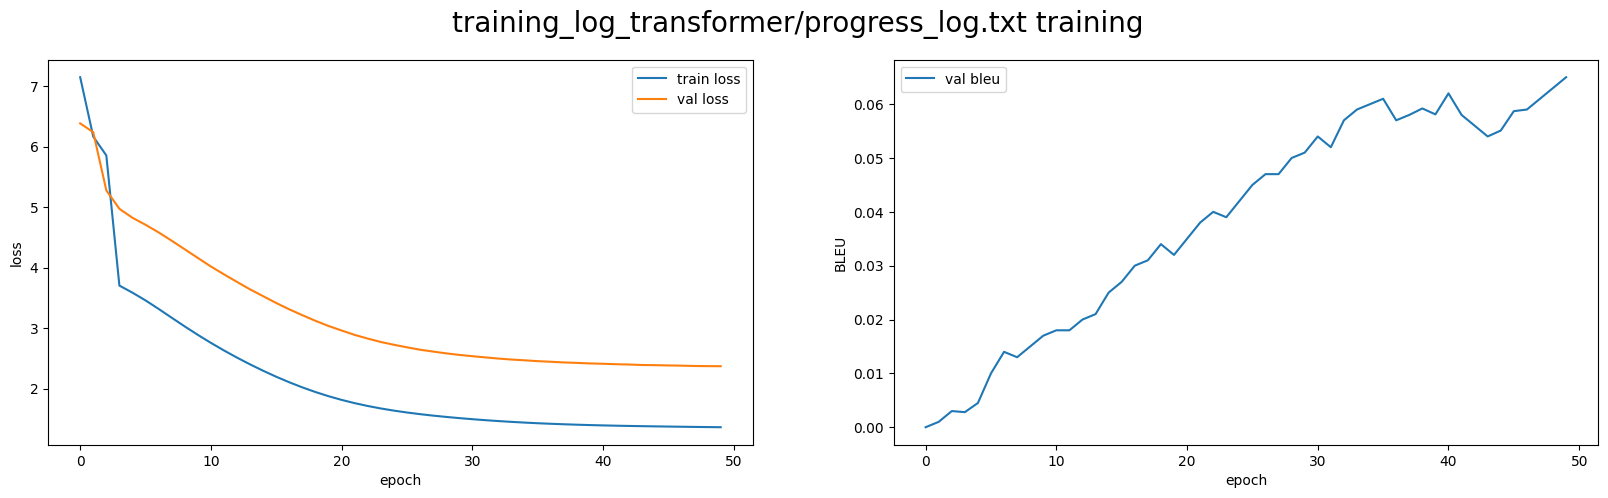

In [5]:
show_plots('training_log_transformer/progress_log.txt')

# Examples
source --- true target --- predicted target

We looked everywhere for you. --- Мы тебя повсюду искали. --- мы нас тебя тебя

Tom put salt in his coffee instead of sugar. --- Том насыпал себе в кофе соль вместо сахара. --- том положил соль кофе кофе кофе кофе кофе

People could have avoided many mistakes by simple experiments. --- Люди могли бы избежать множества ошибок, проводя простые эксперименты. --- люди могут могут могут много много множество для

Can you imagine walking around on the moon? --- Можешь ли ты представить себя прогуливающимся по Луне? --- можешь можете себе позже на на

This is delicious. How did you make it? --- Очень вкусно. Как ты это приготовила? ---  это очень как ты это

What we should do next is the question. --- Вопрос в том, что нам делать дальше. --- что нам делать делать делать вопрос вопрос вопрос

The author of this article is a famous critic. --- Автор этой статьи — известный критик. --- автор из статью статью

The prisoner asked to be released early. --- Заключённый попросил о досрочном освобождении. --- вечеринка попросил уйти пораньше пораньше

Tom was killed instantly when the bomb he was trying to defuse exploded. --- Том мгновенно погиб, когда бомба, которую он пытался обезвредить, взорвалась. --- том убил убил когда когда он он

Do you have a moment to talk about Jesus? --- У Вас есть минутка, чтобы поговорить об Иисусе Христе? --- у вас есть минуту о говорить о

### Fine-tune pretrained T5 (25 баллов)

Реализуйте Seq2seq Pretrained T5. Воспользуйтесь https://huggingface.co/docs/transformers/model_doc/t5 предобученной моделью. В качестве максимальной длинны возьмите предложения длинной **до 15 слов**, без каких либо префиксов. Архитектура модели(количетсво слоев, размерность и тд) остается на ваш выбор.

Не забудьте важные аспекты обучения модели:
* Взять готовый t5 токенизатор
* Resize matrix embedding - скорей всего ваша матрица эмбеддингов не будет включать эмбеддинги из вашего сета. Пример обновления матрицы эмбеддингов тут тут https://github.com/runnerup96/Transformers-Tuning/blob/main/t5_encoder_decoder.py
* Learning rate schedualer/Adafactor with constant learning rate


В качестве результатов, приложите слудующие данные:
1) Параметры обучения - learning rate, batch_size, epoch_num, pretrained model name
2) Графики обучения - train loss, val loss, bleu score
3) Примеры переводов вашей модели(10 штук) - source text, true target text, predicted target text

In [6]:
data_config = yaml.load(open("configs/data_config.yaml", 'r'), Loader=yaml.Loader)
data_config

{'prefix_filter': ['he is', 'he s ', 'she is', 'she s '],
 'max_length': 15,
 'filename': 'rus.txt',
 'train_size': 0.8,
 'batch_size': 128}

In [7]:
model_config = yaml.load(open("configs/model_config_t5.yaml", "r"), Loader=yaml.Loader)
model_config

{'pretrained_model_name': 'google/t5-efficient-mini',
 'learning_rate': 0.003,
 'batch_size': 192,
 'epoch_num': 5}

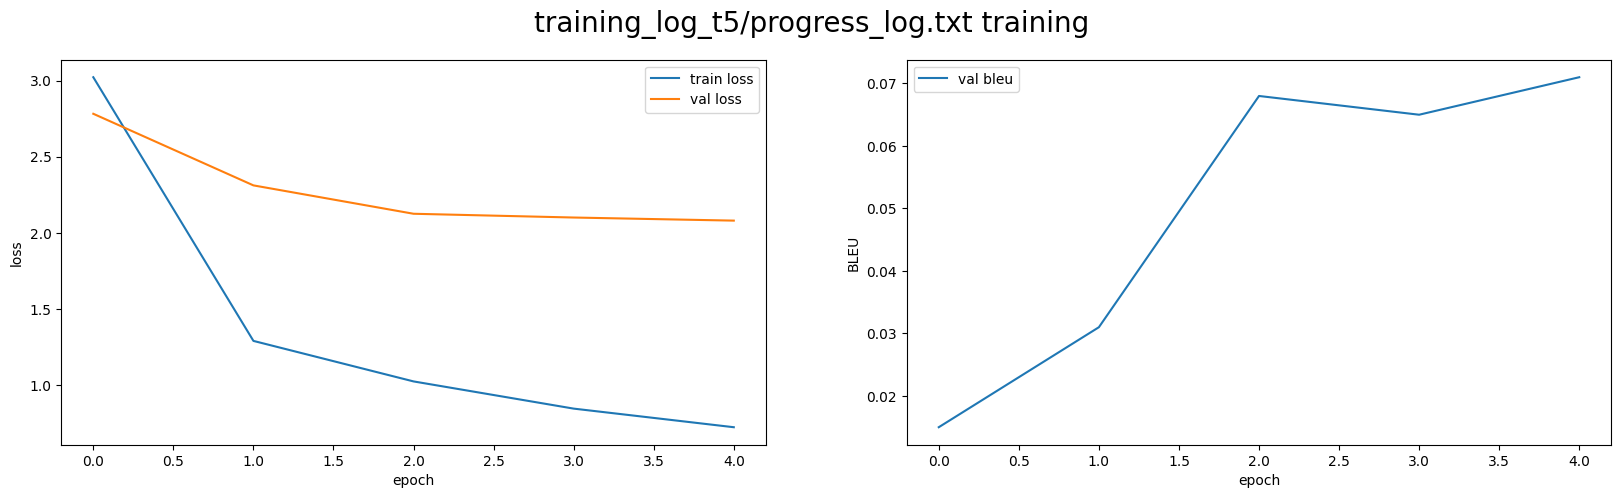

In [8]:
show_plots('training_log_t5/progress_log.txt')

# Examples
Passengers can take a certain amount of baggage on the airplane. --- Пассажиры могут взять на самолёт некоторое количество багажа. --- пассажиры может взять в в в в

Tom didn't like going to school. --- Том не нравилось ходить в школу. --- тому никогда не очень нравилось ходить в школу

Why don't you tell me what you remember? --- Почему ты не расскажешь мне, что ты помнишь? --- почему ты не не мне что что помнишь

More people came to the party than I had bargained for. --- На вечеринку пришло больше народа, чем я рассчитывал. --- больше людей пришло пришло на вечеринку вечеринку у меня я я

There may have been a misunderstanding. --- Возможно, произошло недоразумение. --- можно быть недоразумение недоразумение

Tom is still too young to join the army. --- Том ещё слишком молод, чтобы идти в армию. --- том всё ещё молод чтобы чтобы армию армию армию

What time does the next train to Boston leave? --- Во сколько отправляется следующий поезд до Бостона? --- во сколько следующий следующий поезд бостона бостона бостона

Tom didn't start talking until he was three. --- Том не говорил до трёх лет. --- том не начал говорить до три три три три

There were lots of people in the stadium. --- На стадионе было полно народа. --- в парке было много народа народа

They want to participate in the Olympic Games. --- Они хотят принять участие в Олимпийских играх. --- они хотят участвовать в в в игры игры игры
